# Учимся пользоваться Detectron2

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">


# Устанавливаем detectron2

In [ ]:
!pip install pyyaml

# PyTorch 1.10 + cuda 11.1
# https://pytorch.org/get-started/previous-versions/
!pip uninstall torch torchvision -y
!pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# Detectron2 built for PyTorch 1.10 + cuda 11.1
# https://detectron2.readthedocs.io/en/latest/tutorials/install.html
!pip uninstall detectron2
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html

In [ ]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.10")   # please manually install torch 1.10 if Colab changes its default version

1.10.1+cu111 True


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

# Обучаем модель на новом датасете

Здесь мы рассмотрим как обучить готовую модель detectron2 на новом датасете.

Будем использовать датасет с игроками в баскетбольном матче. Число классов: 2 (две команды). Будем обучать модель сегментации игроков используя уже готовую модель, обученную на COCO датасете.

## Подготовка датасета

In [ ]:
# Скачаем и распакуем данные
#! wget https://disk.yandex.ru/d/thdvaAKQS3ASXA
#!wget https://drive.google.com/file/d/1Jt02Xmth28vkdmRf0TvysbYNpd0OV_2i/view?usp=sharing
! unzip /content/drive/MyDrive/otus_basketball_dataset.zip > /dev/null
img_dir = "/content/otus_basketball_dataset/"


In [ ]:
def get_basketball_dicts(img_dir):

  json_file = os.path.join(img_dir, "anno.json")
  with open(json_file) as f:
    imgs_anns = json.load(f)

  idx = 0
  dataset_dicts = []
  for file_name, img_info in imgs_anns.items():
    record = {}
    filename = os.path.join(img_dir, file_name)
    height, width = cv2.imread(filename).shape[:2]

    record["file_name"] = filename
    record["image_id"] = idx
    record["height"] = height
    record["width"] = width

    objs = []
    annos = list(img_info.values())
    for anno in annos:
      box = anno['box']
      team = anno['team']
      bbox = [float(box[0])*width, float(box[1])*height, float(box[2])*width, float(box[3])*height]

      obj = {
        "bbox": bbox,
        "bbox_mode": BoxMode.XYWH_ABS,
        "category_id": int(team),
      }
      objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)
    idx += 1

  return dataset_dicts


In [ ]:
for d in ["images_train", "images_test"]:
  DatasetCatalog.register("basketball_" + d, lambda d=d: get_basketball_dicts("otus_basketball_dataset/" + d))
  MetadataCatalog.get("basketball_" + d).set(thing_classes=["team 0", "team 1"])

basketball_metadata = MetadataCatalog.get("basketball_images_train")

Для начала зарегистрируем датасет "otus_basketball_dataset" в detectron2, следуя [этому туториалу](https://detectron2.readthedocs.io/tutorials/datasets.html).
Этот датасет имеем свою собственную структуру, поэтому нам нужно написать функцию для парсинга и подготовки этого датасета к внутреннему формату датасетов detectron2.


Визуализируем аннотиции из рандомного сэмпла в train наборе чтобы убедиться что новый датасет подготовлен корректно:



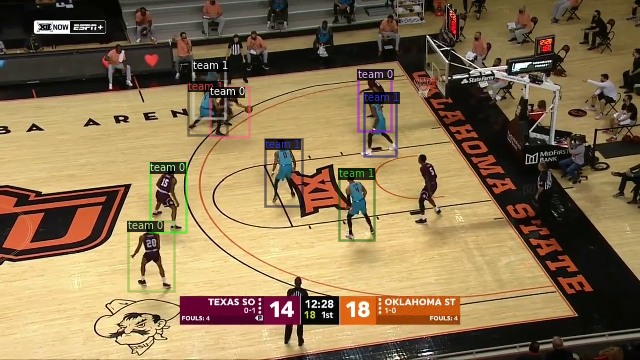

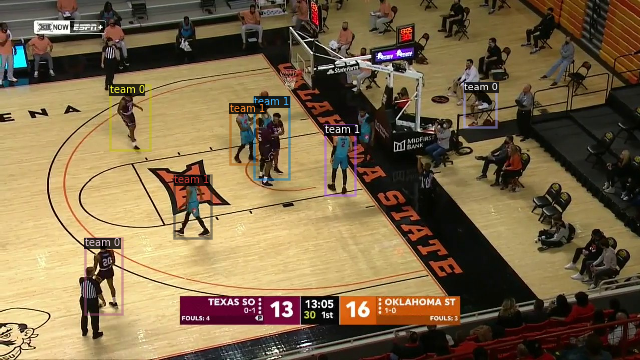

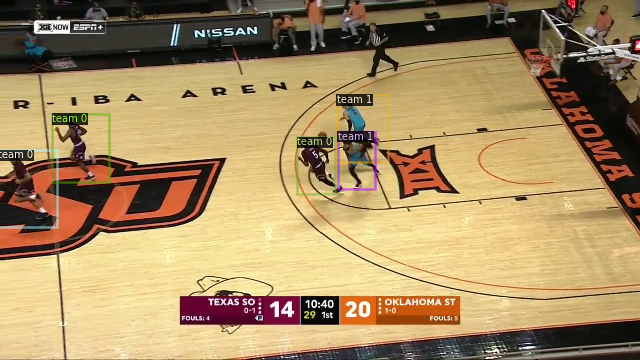

In [ ]:
dataset_dicts = get_basketball_dicts("/content/otus_basketball_dataset/images_train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=basketball_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

## Обучение!

Теперь мы можем дообучить модель R101-C4 Faster R-CNN, предобученную на COCO, на нашем новом датасете "basketball". Будем обучать 2000 итераций.


In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml"))
cfg.DATASETS.TRAIN = ("basketball_images_train",)
cfg.DATASETS.TEST = ("basketball_images_test")
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000    # 2000 iterations seems good enough for this dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 8
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # two classes (team1 & team2). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Инференс и оценка обученной модели
Теперь можно протестировать обученную модель на валидационном сете "basketball". Сперва создадим предиктор для только что обученной модели:



In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Далее, выберем несколько случайных семплов и визуализируем результаты предсказаний.

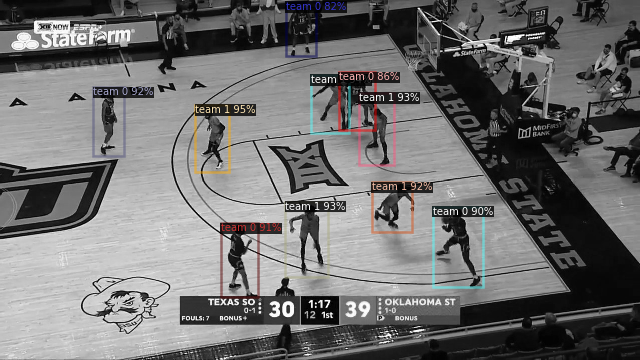

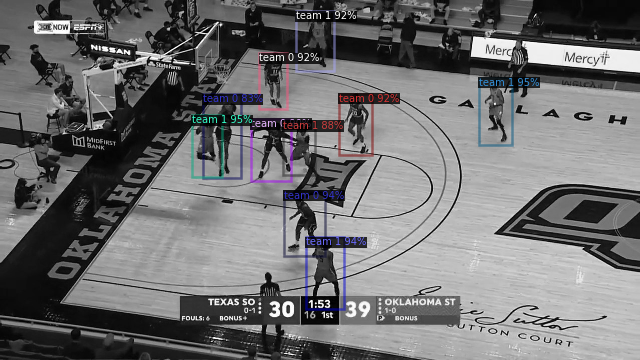

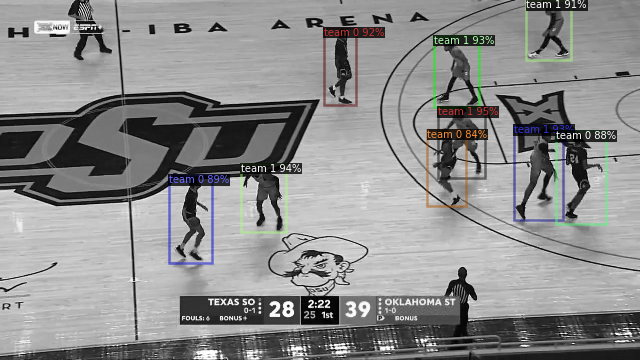

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_basketball_dicts("/content/otus_basketball_dataset/images_test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=basketball_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Также, мы можем оценить производительность модели используя AP метрику, реализованную в COCO API. Это должно дать AP=~70!

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("basketball_images_test", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "basketball_images_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[12/17 11:05:40 d2.evaluation.coco_evaluation]: Trying to convert 'basketball_images_test' to COCO format ...
[12/17 11:05:40 d2.data.datasets.coco]: Converting annotations of dataset 'basketball_images_test' to COCO format ...)
[12/17 11:05:41 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[12/17 11:05:41 d2.data.datasets.coco]: Conversion finished, #images: 100, #annotations: 660
[12/17 11:05:41 d2.data.datasets.coco]: Caching COCO format annotations at './output/basketball_images_test_coco_format.json' ...
[12/17 11:05:42 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   team 0   | 377          |   team 1   | 283          |
|            |              |            |              |
|   total    | 660          |            |              |
[12/17 11:05:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [Res

# Other types of builtin models

We showcase simple demos of other types of models below:

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


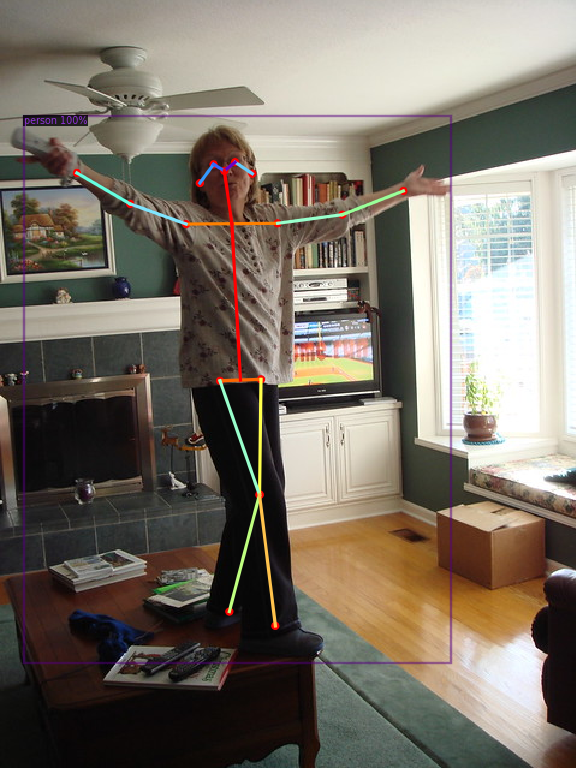

In [ ]:
# Image:
!wget http://farm3.staticflickr.com/2790/4239964072_6947d0a3c6_z.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")

# Inference with a keypoint detection model
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


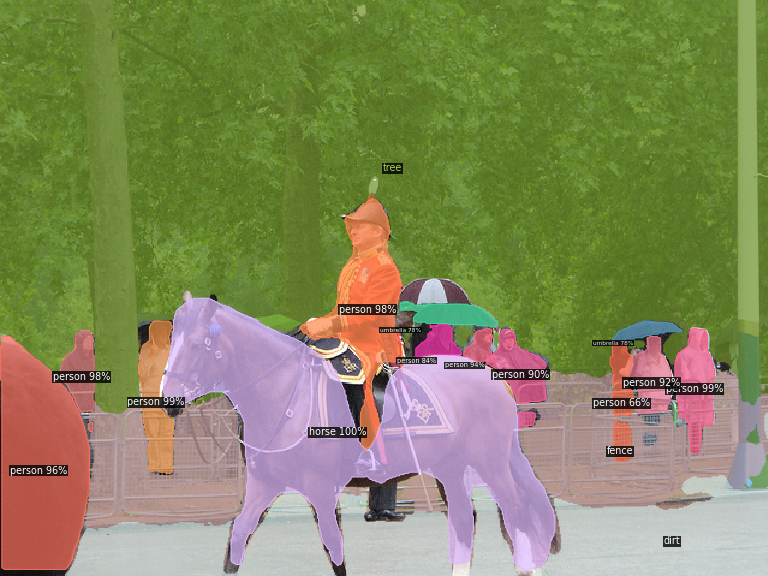

In [ ]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])

Using model new_baselines/mask_rcnn_R_101_FPN_400ep_LSJ.py


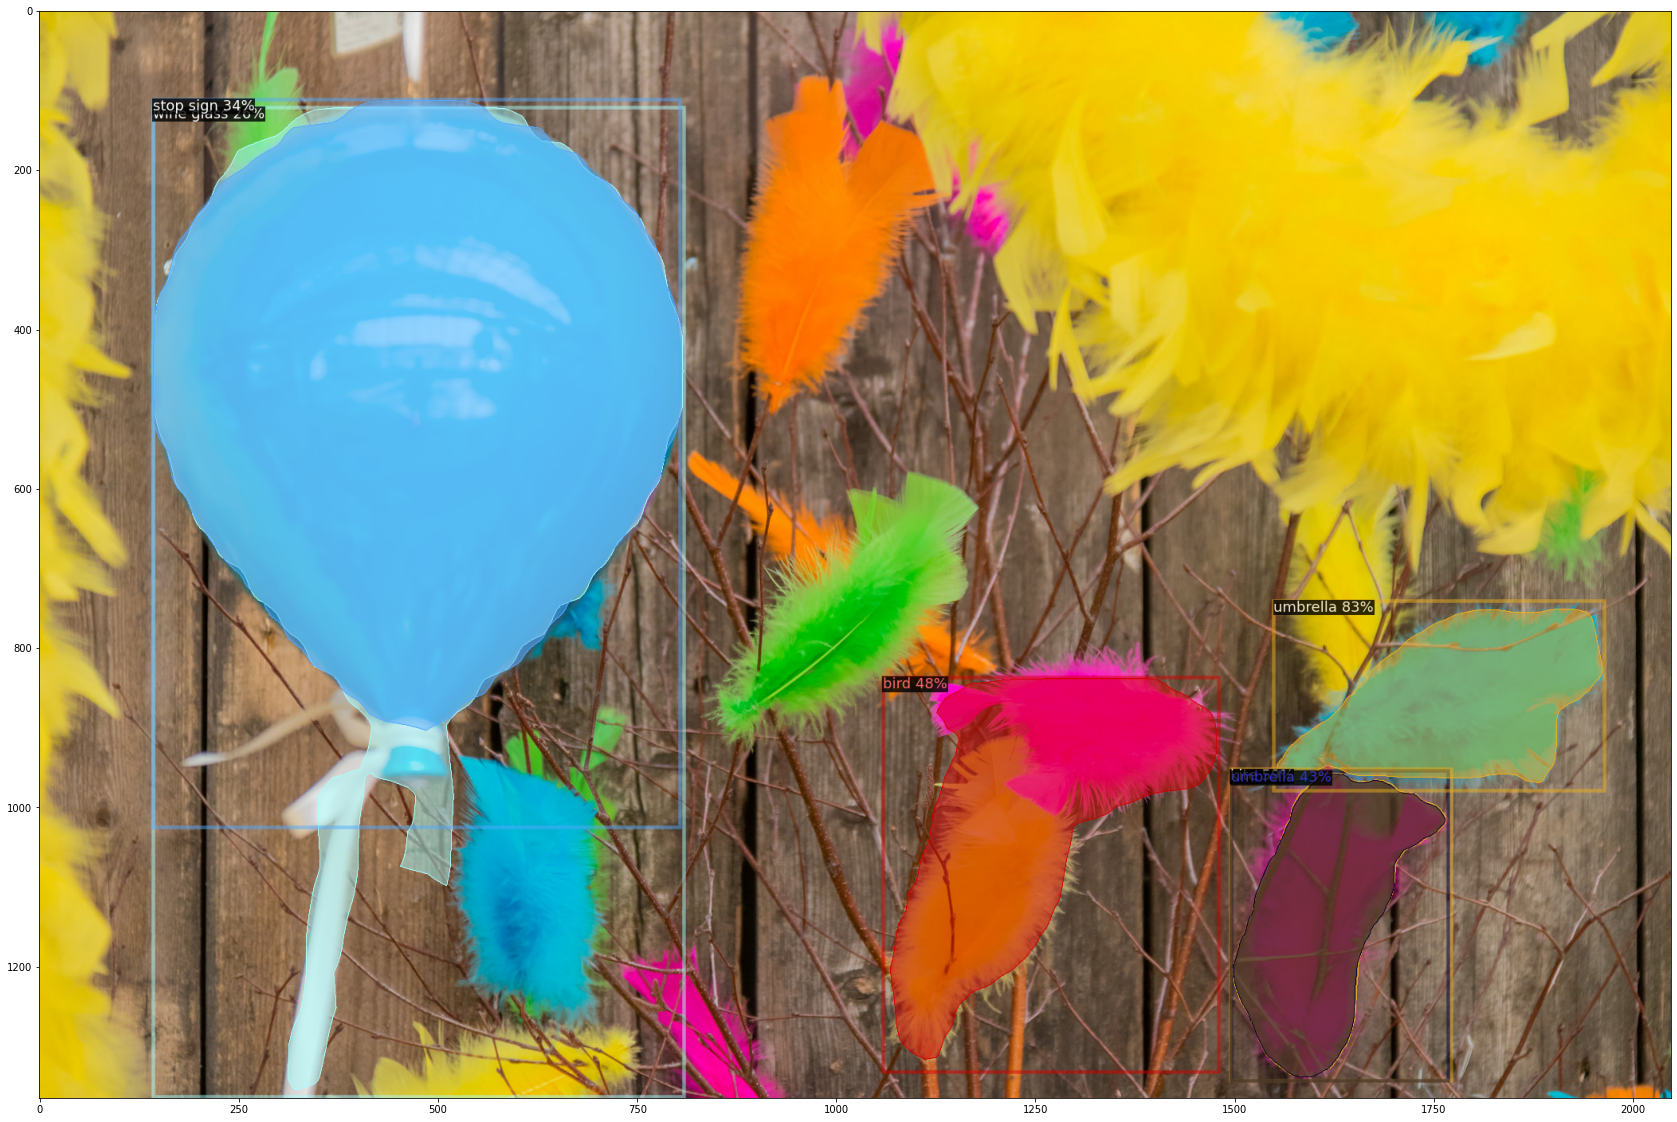

In [ ]:
# import some common detectron2 utilities:
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg, instantiate
from detectron2.data import MetadataCatalog
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.visualizer import Visualizer

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [30, 20]

class SegmentatorNewBaseline:
    def __init__(self, model_name, threshold=0.5):
        print ('Using model', model_name)
        
        # Get model config and weights (download if it doesn't exist):
        self.cfg = model_zoo.get_config(model_name, trained=True)
        self.cfg['model']['roi_heads']['box_predictor']['test_score_thresh'] = threshold
        
        # Init:
        self.model = instantiate(self.cfg.model)
        
        # Load a checkpoint:
        DetectionCheckpointer(self.model).load(self.cfg.train.init_checkpoint)
        
        self.model.eval()
        self.model.to('cuda')

    def __call__(self, img, viz=False):
        # Preprocess input image:
        img_tensor = torch.from_numpy(img)
        img_tensor = torch.permute(img_tensor, (2, 0, 1))
        batch = [{"image": img_tensor.to('cuda')}]
        
        # Inference:
        with torch.no_grad():
            outputs = self.model(batch)[0]

        # Vizualize:
        if viz:
            v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(self.cfg['dataloader']['train']['dataset']['names']), scale=1.0)
            img = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()
            plt.imshow(img)
            plt.show()

        return outputs


segmentator = SegmentatorNewBaseline('new_baselines/mask_rcnn_R_101_FPN_400ep_LSJ.py', 0.25)
outputs = segmentator(img, viz=True)

# Run panoptic segmentation on a video

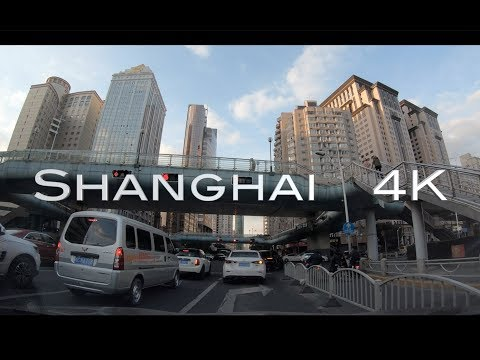

In [ ]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("ll8TgCZ0plk", width=500)
display(video)

In [ ]:
# Install dependencies, download the video, and crop 5 seconds for processing
!pip install youtube-dl
!youtube-dl https://www.youtube.com/watch?v=ll8TgCZ0plk -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:06 -c:v copy video-clip.mp4

In [ ]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes) with the "demo.py" tool we provided in the repo.
!git clone https://github.com/facebookresearch/detectron2
# Note: this is currently BROKEN due to missing codec. See https://github.com/facebookresearch/detectron2/issues/2901 for workaround.
%run detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output video-output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

In [ ]:
# Download the results
from google.colab import files
files.download('video-output.mkv')